In [3]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, utils, datasets
import matplotlib.pyplot as plt
import os
import sys
if '/opt/ros/kinetic/lib/python2.7/dist-packages' in sys.path:
    sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')
import cv2
import numpy as np
from skimage import io
from PIL import Image
from shutil import copyfile
import csv

### 1. Define training parameter

In [4]:
EPOCH = 30                # train the training data n times, to save time, we just train 1 epoch
BATCH_SIZE = 12
INPUT_SIZE = 227         # img input size
LR = 0.001               # learning rate
TEST = False
validation_ratio = 0.1

### 2. Split grocery data to training and testing data

In [7]:
data_path = '~/sis_lab_all/11-Deep_Learning_3/images'
train_path = '~/sis_lab_all/11-Deep_Learning_3/grocery/train'
test_path = '~/sis_lab_all/11-Deep_Learning_3/grocery/test'
if not os.path.isdir(data_path):
    os.makedirs(data_path)
if not os.path.isdir(train_path):
    os.makedirs(train_path)
if not os.path.isdir(test_path):
    os.makedirs(test_path)

classes = os.listdir(data_path)
print('Print all of class in the dataset: ')
print(classes)
for cla in classes:
    grocery_path = os.path.join(data_path, cla)
    train_grocery_path = os.path.join('/hosthome/sis_lab_all/11-Deep_Learning_3/grocery/train', cla)
    test_grocery_path = os.path.join('/hosthome/sis_lab_all/11-Deep_Learning_3/grocery/test', cla)
    filename_list = sorted(os.listdir(grocery_path))
    if not os.path.isdir(train_grocery_path):
        os.makedirs(train_grocery_path)
    if not os.path.isdir(test_grocery_path):
        os.makedirs(test_grocery_path)
    file_num = len(filename_list)
    split_id = int(file_num * (1-validation_ratio))
    for i in range(0, split_id):
        file_path = os.path.join(grocery_path, filename_list[i])
        save_path = os.path.join(train_grocery_path, filename_list[i])
        copyfile(file_path, save_path)
    for i in range(split_id, file_num):
        file_path = os.path.join(grocery_path, filename_list[i])
        save_path = os.path.join(test_grocery_path, filename_list[i])
        copyfile(file_path, save_path)  

Print all of class in the dataset: 
[]


### 3.1 Define network: GroceryNet from this paper [link](http://ais.informatik.uni-freiburg.de/publications/papers/jund16groceries.pdf)

In [4]:
class GroceryNet(nn.Module):
    def __init__(self):
        super(GroceryNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 96, 11, 4, 0, bias=True) #in, out, kernel, stride, padding
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d((3, 3), 2)
        self.norm1 = nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75)

        self.conv2 = nn.Conv2d(96, 256, 5, 1, 2, groups=2, bias=True) #in, out, kernel, stride, padding
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d((3, 3), 2)
        self.norm2 = nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75) 

        self.conv3 = nn.Conv2d(256, 384, 3, 1, 1, bias=True) #in, out, kernel, stride, padding
        self.relu3 = nn.ReLU()
        
        self.conv4 = nn.Conv2d(384, 384, 3, 1, 1, groups=2, bias=True) #in, out, kernel, stride, padding
        self.relu4 = nn.ReLU()

        self.conv5 = nn.Conv2d(384, 256, 3, 1, 1, groups=2, bias=True) #in, out, kernel, stride, padding
        self.relu5 = nn.ReLU()
        self.pool5 = nn.MaxPool2d((3, 3), 2)

        self.fc6   = nn.Linear(256 * 6 * 6, 4096, bias=True)
        self.relu6 = nn.ReLU()
        self.drop6 = nn.Dropout2d(0.5)

        self.fc7   = nn.Linear(4096, 4096, bias=True)
        self.relu7 = nn.ReLU()
        self.drop7 = nn.Dropout2d(0.5)

        self.fc8finetune = nn.Linear(4096, 25, bias=True)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.norm1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.norm2(x)

        x = self.conv3(x)
        x = self.relu3(x)

        x = self.conv4(x)
        x = self.relu4(x)

        x = self.conv5(x)
        x = self.relu5(x)
        x = self.pool5(x)

        x = x.view(-1, 256*6*6) #flatten data

        x = self.fc6(x)
        x = self.relu6(x)
        x = self.drop6(x)

        x = self.fc7(x)
        x = self.relu7(x)
        x = self.drop7(x)

        output = self.fc8finetune(x)
        return output

### 4. Define dataloader

In [5]:
# Because we used the pretrained model converted from caffemodel.
# We want to match the predicted label quickly with author's declaration, so we define the transform list here.
label_transfrom_list = np.asarray([2, 12, 23, 15, 5, 16, 17, 13, 19, 10, 11, 14, 4, 18, 6, 0, 21, 7, 3, 1, 20, 24, 9, 22, 8])
inverse_transfrom_list = torch.tensor([15, 19, 18, 0, 12, 4, 14, 17, 24, 22, 9, 10, 1, 7, 11, 3, 5, 6, 13, 8, 20, 16, 23, 2, 21]).cuda()

In [6]:
def load_grocery_data(bt = BATCH_SIZE, mode = 'train', suf=True):
    fpath = '/hosthome/sis_lab_all/11-Deep_Learning_3/grocery'
    fpath = os.path.join(fpath, mode)
    data_transform = transforms.Compose([
            transforms.Resize(INPUT_SIZE),
            #transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(
               mean=[0.485, 0.456, 0.406],
               std=[0.229, 0.224, 0.225])
    ])
    data = datasets.ImageFolder(root = fpath, \
                                           transform = data_transform)
    data_loader = torch.utils.data.DataLoader(dataset = data, \
                                                 batch_size = bt, \
                                                 shuffle = suf)
    return data_loader

### 5. Define img visualization

In [7]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.rcParams['figure.figsize'] = [12, 5]
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
def vis_img(data):   
    dataiter = iter(data)
    images, labels = dataiter.next()
    # show images
    imshow(torchvision.utils.make_grid(images))

### 6. Train

In [ ]:
def train_caffenet(model_filename=None):
    # Define training data
    train_loader = load_grocery_data()
#     vis_img(train_loader)
    
    # Define model, optimizer and loss function
    print('Load training model')    
    state_dict = torch.load('_iter_10000.pth') # you need to download the pretrained model first
    model = GroceryNet().cuda().train()
    model.load_state_dict(state_dict)
    
#     optimizer = torch.optim.Adam(model.parameters(), lr = LR)   # optimize all cnn parameters
    optimizer = torch.optim.SGD(model.parameters(), lr = LR, momentum=0.9, weight_decay=0.0005)
    loss_func = nn.CrossEntropyLoss()
    
    running_loss = 0.
    cnt = 0
    if not os.path.isdir('/hosthome/sis_lab_all/11-Deep_Learning_3/grocery/model/'):
        os.makedirs('/hosthome/sis_lab_all/11-Deep_Learning_3/grocery/model/')
    for epoch in range(EPOCH):
        print('========== Epoch: ', epoch, ' ==========')
        for step, data in enumerate(train_loader):
            cnt = cnt + 1
            imgs = data[0].cuda()
            labels = data[1].cuda()
            optimizer.zero_grad()
            outputs = model(imgs)
        
            loss = loss_func(outputs, inverse_transfrom_list[labels])
            loss.backward()
            optimizer.step()
            if cnt % 50 == 0:
                print ('loss: ', loss.item())
        model_name = '/hosthome/sis_lab_all/11-Deep_Learning_3/grocery/model/net_{}.pth'.format(epoch)
        torch.save(model, model_name)
        print('----- Save model: {} -----'.format(model_name))
    print('Finish Training')

In [ ]:
train_caffenet()

### 6. Predict

In [8]:
def test_caffenet(weight_file = '29'):
    weight_path = '/hosthome/sis_lab_all/11-Deep_Learning_3/grocery/model/net_{}.pth'.format(weight_file)
    test_loader = load_grocery_data(bt = BATCH_SIZE, mode = 'test', suf=True)
    data_iter = iter(test_loader)
    data = data_iter.next()  
    
    # Load entire model directly and set it to evaluation mode
    print('Load trained model')
    model = torch.load(weight_path)
    model = model.cuda().eval()
    
    outputs = model(data[0].cuda())    
    pred_y = torch.max(outputs, 1)[1].cpu().numpy()
    print ('Prediction: ', label_transfrom_list[pred_y])
    print ('Ground truth: ', data[1].cpu().numpy())
    vis_img(test_loader)

In [14]:
def calc_accuracy(weight_file = '29'):
    weight_path = '/hosthome/sis_lab_all/11-Deep_Learning_3/grocery/model/net_{}.pth'.format(weight_file)
    test_loader = load_grocery_data(bt = BATCH_SIZE, mode = 'test', suf=True)
    
    # Load entire model directly and set it to evaluation mode
    model = torch.load(weight_path)
    model = model.cuda().eval()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = model(images.cuda())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (label_transfrom_list[predicted] == labels.cuda()).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))


Load trained model
Prediction:  [22  1  3 21  6  2 21 14  6  3 12 24]
Ground truth:  [18  2  1  5 19 14 21  5  6  2 12  2]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Accuracy of the network on the 10000 test images: 50 %


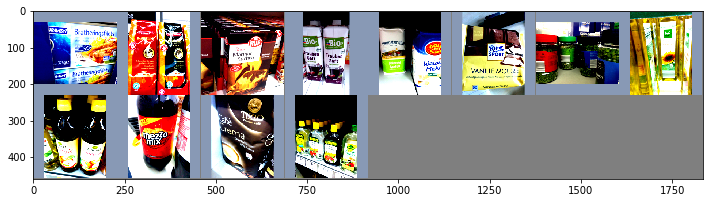

In [15]:
test_caffenet(weight_file='29')
calc_accuracy(weight_file='29')

### Generate confusion matrix

In [10]:
def test_confution_matrix(weight_file = '29'):
    weight_path = '/hosthome/sis_lab_all/11-Deep_Learning_3/grocery/model/net_{}.pth'.format(weight_file)
    data_loader = load_grocery_data(bt=1, mode = 'test',suf=False)
    data_iter = iter(data_loader)
    print('Data size: ', len(data_iter))
    #Define model
    print('Load training model')
    
    # Load entire model directly and set it to evaluation mode
    model = torch.load(weight_path)
    model = model.cuda().eval()
    
    count = 0
    test_label_list = []
    predict_list = []
    label_list = []
    
    # Get class id as same as which pytorch does
    dir = '/hosthome/sis_lab_all/11-Deep_Learning_3/images'
    classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
    classes.sort()
    cls = {classes[i]: i for i in range(len(classes))}
    value = list(cls.values())
    key = list(cls.keys())
    for i in range(len(classes)):
        label_list.append([key[value.index(i)], i])
    
    for i in range(len(data_iter)):
        data = next(data_iter)
        outputs = model(data[0].cuda())
        predict = torch.max(outputs, 1)[1].cpu().numpy()
        predict = int(label_transfrom_list[predict])
        label = int(data[1].cpu().numpy())
        predict_list.append(predict)
        test_label_list.append(label)
        count += 1
    print(count)
    
    # Calculate the confusion matrix
    over_all_correct = 0
    with open('/hosthome/sis_lab_all/11-Deep_Learning_3/grocery/confusion_matrix.csv', 'w+') as csvfile:
        writer = csv.writer(csvfile)
        for row in range(26):
            data = []
            each_pred = np.zeros(len(data_iter), np.int16)
            target_label = row - 1
            image_counter = 0
            if row == 0:
                data.append('')
            else:
                tmp = str(label_list[target_label][1])+":"+label_list[target_label][0]
                data.append(tmp)
                
                # Calculate accuracy
                for i in range(len(test_label_list)):
                    if test_label_list[i] == target_label:
                        image_counter += 1
                        each_pred[predict_list[i]] += 1
                        if predict_list[i] == target_label:
                            over_all_correct += 1 
            for col in range(25):
                if row == 0:
                    data.append(label_list[col][0])    
                else:
                    data.append(float(each_pred[col])/image_counter)
            writer.writerow(data)

        writer.writerow(['overall accuracy:', float(over_all_correct)/len(data_iter)])
        print('Finished')

In [11]:
test_confution_matrix()

Data size:  507
Load training model
507
Finished
